In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import interpolate
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar

In [2]:
data = pd.read_csv('data_for_visualization_with_tones_v1.csv', index_col='id')

In [3]:
# убираем бессмысленный ворнинг
pd.options.mode.chained_assignment = None

In [4]:
confident_data = data[data.best_topic_weights >= 0.6]
# confident_data = confident_data.drop_duplicates(subset="name")
confident_data['week'] = confident_data.copy().formated_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
confident_data = confident_data[confident_data['week'] != '2021-00']


confident_data_sum = confident_data.groupby(['formated_date']).agg(['count'])['date']
confident_data_sum_week = confident_data_sum.copy()
confident_data_sum_week['week'] = confident_data_sum_week.index.to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
confident_data_sum_week = confident_data_sum_week.groupby(['week']).agg(['sum'])['count']
confident_data_sum_week['date'] = list(map(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').strftime('%Y-%m-%d'), confident_data_sum_week.index.to_list()))
topic_counter = confident_data.groupby(['best_topic_label', 'week']).agg(['count'])['date']

confident_data['month'] = confident_data.formated_date.apply(lambda x: x[:7])
# topic_counter = data.loc[topic_label]

cov = pd.read_csv('/home/mchelushkin/Downloads/owid-covid-data.csv')
cov = cov[cov.location == 'Russia']

In [5]:
def find_nearest(array, value):
    array = np.asarray([datetime.strptime(x_, '%Y-%m-%d').timestamp() for x_ in array])
    value = datetime.strptime(value, '%Y-%m-%d').timestamp()
    idx = (np.abs(array - value)).argmin()
    return idx

In [6]:
def get_color(dict_):
    if 'negative' not in dict_:
        dict_['negative'] = 0
    if 'positive' not in dict_:
        dict_['positive'] = 0
    if 'neutral' not in dict_:
        dict_['neutral'] = 0
    if dict_['negative'] > dict_['neutral'] and dict_['negative'] > dict_['positive']:
        return 'red'
    if dict_['positive'] > dict_['neutral'] and dict_['positive'] > dict_['negative']:
        return 'green'
    if dict_['neutral'] - dict_['positive'] > 0.1 and dict_['neutral'] - dict_['negative'] > 0.1:
        return 'yellow'
    elif dict_['neutral'] - dict_['positive'] < 0:
        return 'light-green'
    else:
        return 'orange'
from heapq import nlargest
import json
def sum_two_dicts(dict1, dict2):
    for x in dict2:
        if x in dict1:
            dict1[x] += dict2[x]
        else:
            dict1[x] = dict2[x]
    return dict1

def f(x):
    dict_ans = {}
    for d in x.tones:
        conv_d = json.loads(d.replace('\'','\"'))
        dict_ans = sum_two_dicts(dict_ans, conv_d)
    total = len(x.tones)
    for x in dict_ans:
        dict_ans[x] /= total
    ans = {}
    for x in nlargest(2, dict_ans, key = dict_ans.get):
        ans[x] = dict_ans[x]
    return ans

In [7]:
topics_to_keep = [1, 4, 5, 6, 7, 10, 11, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25]
topic_names = ['Обсуждения болезни', 'Cредства защиты', 'Животные вирусы','Статистика',
               'Деньги/Бизнес', 'Народные советы', 'Самоизоляция',
              'Права человека', 'Власть', 'Трудности из-за изоляции', 'Вакцина',
              'Религия', 'Сравнение с Гриппом', 'Отец работает в X',
              'Иммунитет', 'Общение', 'Копипаста']

In [8]:
events = [
    {'name': 'Масочный режим', 'date': '2020-05-12', 'color':'cyan'}, # 0
    {'name': 'Первая смерть', 'date': '2020-03-19', 'color':'black'}, # 1
    {'name': 'Пропускной режим', 'date': '2020-04-13', 'color':'gray'}, # 2
    {'name': 'Опровержение второго карантина', 'date': '2020-10-05', 'color':'purple'}, # 3
    {'name': 'Самоизоляция в Москве', 'date':'2020-03-30', 'color':'red'}, # 4
    {'name': 'Введение нерабочих дней', 'date':'2020-03-25', 'color':'pink'}, # 5
    {'name': 'Продление нерабочих дней', 'date':'2020-04-02', 'color':'pink'}, # 6
    {'name': 'Продление нерабочих дней', 'date':'2020-04-28', 'color':'pink'}, # 7
    {'name': 'Отмена самоизоляции', 'date':'2020-06-09', 'color':'orange'}, # 8
    {'name': 'Регистрация СпутникV в минздраве', 'date':'2020-08-11',  'color':'green'}, # 9
    {'name': 'Поручение о массовой вакцинации', 'date':'2021-01-13',  'color':'blue'}, # 10
    {'name': 'Возвращение на дистант в школе', 'date':'2020-10-18',  'color':'yellow'}, # 11
    {'name': 'Поправки в конституцию', 'date':'2020-06-26',  'color':'magenta'}, # 12
    {'name': 'Митинг', 'date':'2021-01-23', 'color':'magenta'}, # 13
    {'name': 'Лукаш', 'date':'2020-01-30', 'color':'red'}, # 14
]

# 

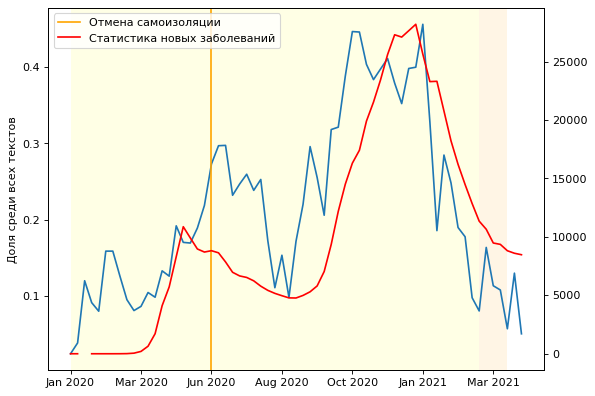

In [42]:
topic = 1
data = topic_counter.loc[topic]
events_to_add = [8]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
ax2 = ax1.twinx()
ax1.plot(x, y)
cov_line, = ax2.plot(x, covid_y, 'r-', label = 'Статистика новых заболеваний')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# plt.set_label('Label via method')
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
# ax1.set_label('123')
# plt.xlabel('123')
# ax2.set_ylabel('Кол-во новых заболеваний')
ax1.set_ylabel('Доля среди всех текстов')
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
added_events.append(cov_line)
plt.legend(handles=added_events)
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig1.png')
plt.show()

# 

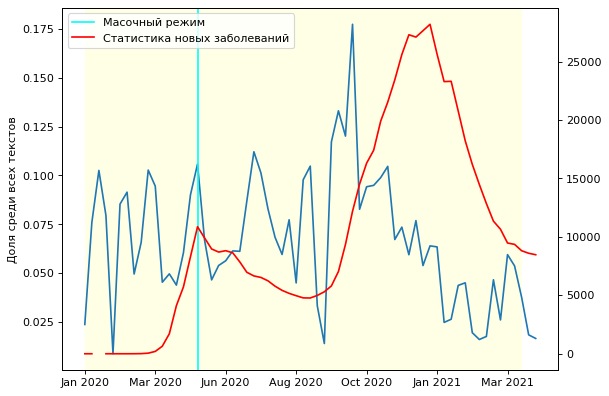

In [43]:
topic = 4
data = topic_counter.loc[topic]
events_to_add = [0, ]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

# fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)

ax2 = ax1.twinx()
ax1.plot(x, y)
cov_line, = ax2.plot(x, covid_y, 'r-', label='Статистика новых заболеваний')
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))

tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])

# plt.legend(handles=added_events)
# ax1.set_ylabel('Доля среди всех текстов')
added_events.append(cov_line)
plt.legend(handles=added_events)
# plt.legend(added_events, ['label1', 'label2'])
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig2.png')
plt.show()

# 

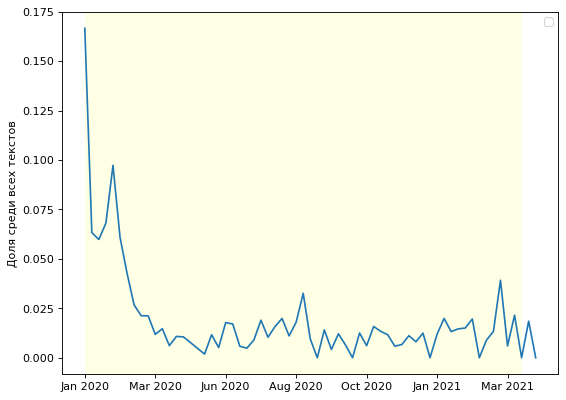

In [44]:
topic = 5
data = topic_counter.loc[topic]
events_to_add = []
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# plt.set_label('Label via method')
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig3.png')
plt.legend(handles=added_events)
plt.show()

# 

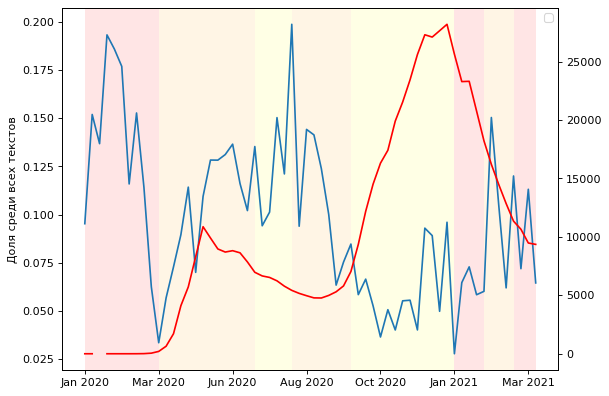

In [45]:
topic = 6
data = topic_counter.loc[topic]
events_to_add = []
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-3]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig4.png')
plt.legend(handles=added_events)
plt.show()

# 

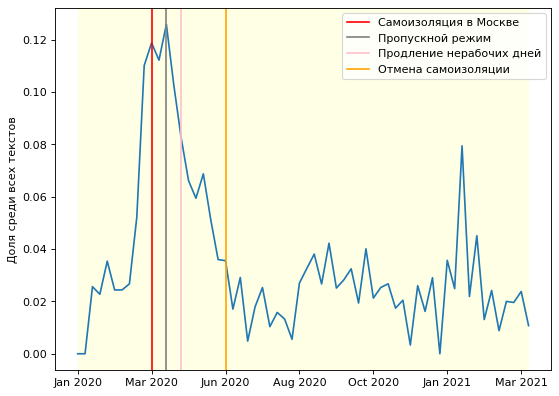

In [46]:
topic = 7
data = topic_counter.loc[topic]
events_to_add = [4, 2, 7, 8]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-3]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig5.png')
plt.legend(handles=added_events)
plt.show()

# 

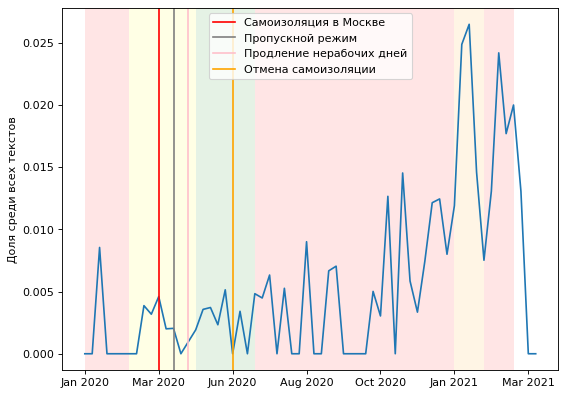

In [47]:
topic = topics_to_keep[5]
data = topic_counter.loc[topic]
events_to_add = [4, 2, 7, 8]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-3]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig6.png')
plt.legend(handles=added_events)
plt.show()

# 

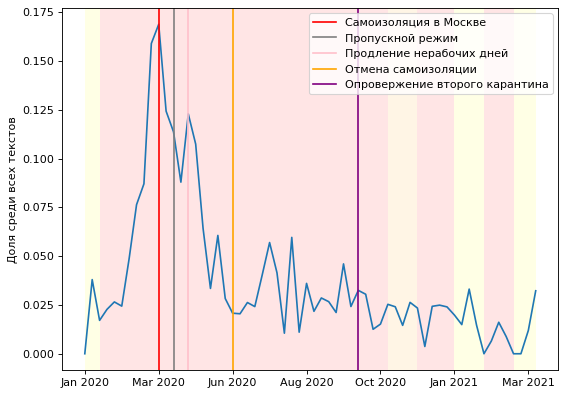

In [48]:
topic = topics_to_keep[6]
data = topic_counter.loc[topic]
events_to_add = [4, 2, 7, 8, 3]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-3]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig7.png')
plt.legend(handles=added_events)
plt.show()

# 

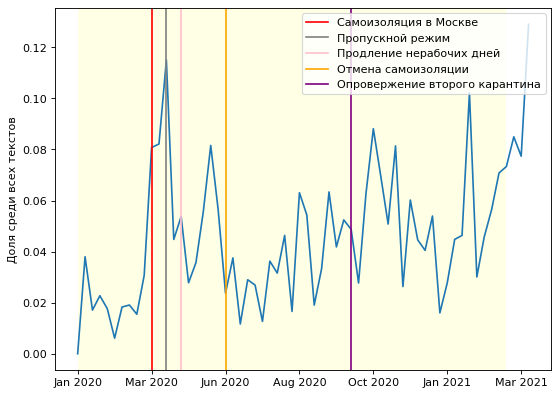

In [49]:
topic = topics_to_keep[7]
data = topic_counter.loc[topic]
events_to_add = [4, 2, 7, 8, 3]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-3]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig8.png')
plt.legend(handles=added_events)
plt.show()

# 

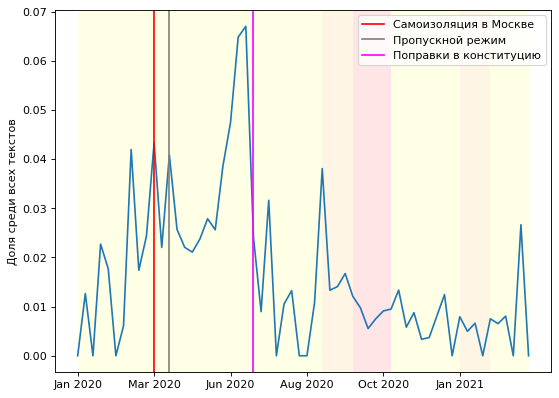

In [50]:
topic = topics_to_keep[8]
data = topic_counter.loc[topic]
events_to_add = [4, 2, 12]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-5]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig9.png')
plt.legend(handles=added_events)
plt.show()

# 

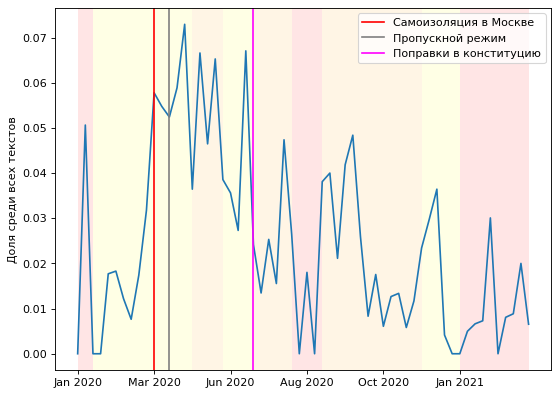

In [51]:
topic = topics_to_keep[9]
data = topic_counter.loc[topic]
events_to_add = [4, 2, 12]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-5]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig10.png')
plt.legend(handles=added_events)
plt.show()

# 

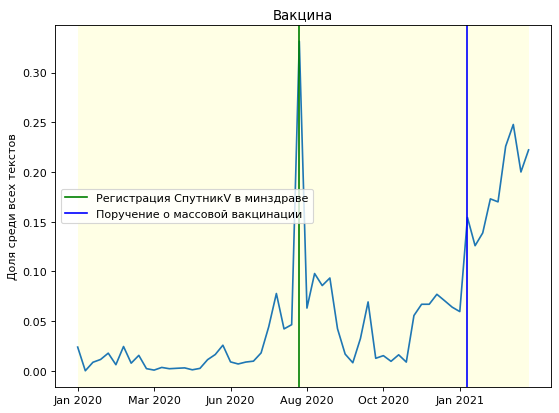

In [52]:
topic = topics_to_keep[10]
data = topic_counter.loc[topic]
events_to_add = [9, 10]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-5]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 

# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.1)
    L = R
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
plt.title(topic_names[topics_to_keep.index(topic)])
# plt.savefig('visualization/fig11.png')
plt.legend(handles=added_events)
plt.show()

# 

# 

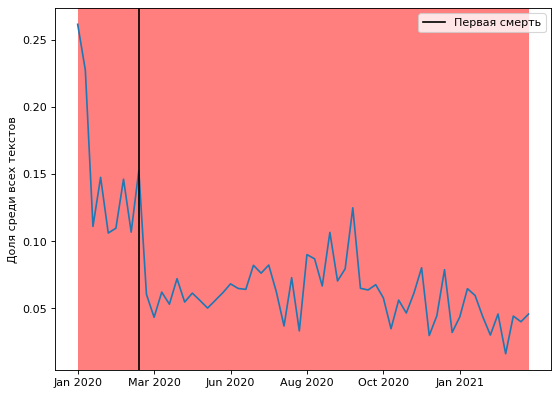

In [53]:
topic = topics_to_keep[12]
# topic = topics_to_keep[14]
data = topic_counter.loc[topic]
tones_months = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
events_to_add = [1]
added_events = []
y = []
x_label= []
x = []
covid_y = []
for date in confident_data_sum_week.index[:-5]:
    x.append(confident_data_sum_week.loc[date].date)
    x_label.append(datetime.strptime(confident_data_sum_week.loc[date].date, '%Y-%m-%d').strftime('%b %Y'))
    try:
        covid_y.append(cov[cov['date'] == confident_data_sum_week.loc[date].date].new_cases_smoothed.values[0])
    except:
        covid_y.append(0)
    try:
        y.append(data.loc[date].values[0] / confident_data_sum_week.loc[date].values[0])
    except:
        y.append(0)


fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
# figure(figsize=(8, 6), dpi=80)
# ax2 = ax1.twinx()
ax1.plot(x, y)
# ax2.plot(x, covid_y, 'r-')
# added_events = []
for i in events_to_add:
    event = events[i]
    added_events.append(ax1.axvline(x=find_nearest(x, event['date']), ymin=0, ymax=1, color=event['color'], label=event['name']))
# line = 
tones = confident_data[confident_data.best_topic_label == topic].groupby(['month']).apply(f)
L = x[0]
for i in range(1, len(tones)):
    R = x[find_nearest(x, datetime.strptime(tones.index[i], '%Y-%m').strftime('%Y-%m-%d'))]
#     print(get_color(tones.iloc[i]))
    ax1.axvspan(L, R, facecolor=get_color(tones.iloc[i]), alpha=0.5)
    L = R
# ax1.get_ylim()
# plt.plot(x, y)
# plt.plot(x, covid_y)
plt.xticks(x[::10], x_label[::10])
# plt.ylabel(topic_label)
# plt.legend()
ax1.set_ylabel('Доля среди всех текстов')
# plt.title(topic_names[topics_to_keep.index(topic)])
plt.savefig('visualization/fig13.png')
plt.legend(handles=added_events)
plt.show()

In [38]:
tmp = topic_counter.reset_index()
# tmp = tmp1.reset_index()
tmp = tmp[tmp['week'] != '2021-16']
tmp['date'] = list(map(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').strftime('%Y-%m-%d'), tmp.week.to_list()))
tmp['date'].unique()

array(['2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10',
       '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09',
       '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06',
       '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04',
       '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01',
       '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29',
       '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27',
       '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
       '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
       '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
       '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
       '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08',
       '2021-03-15', '2021-03-22', '2021-03-29', '2021-

In [41]:
len(dates)

65

In [46]:
dates = tmp['date'].unique()
tmp[tmp['best_topic_label'] == 1].date

0     2020-01-20
1     2020-01-27
2     2020-02-03
3     2020-02-10
4     2020-02-17
         ...    
61    2021-03-15
62    2021-03-22
63    2021-03-29
64    2021-04-05
65    2021-04-12
Name: date, Length: 66, dtype: object

# Графики для каждого топика

In [5]:
def week_number_of_month(date_value):
    date_value = datetime.strptime(date_value + '-1', '%Y-%U-%w')
    return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)

In [6]:
def trimed_data_indexes(array):
    first_non_zero = 0
    last_non_zero = len(array) - 1
    while first_non_zero < len(array) and array[first_non_zero] == 0:
        first_non_zero+=1
    while last_non_zero > 0 and array[last_non_zero] == 0:
        last_non_zero-=1
    return first_non_zero, last_non_zero + 1

In [7]:
def plot_for_topic_weeks_(data, topic_label, all_datetimes, s):
    topic_counter = data.loc[topic_label]
    
    y = []
    weeknumbers = []
    weeklen = []
    for date in all_datetimes.index:
        weeknumbers.append(week_number_of_month(date))
        
        full_date = all_datetimes.loc[date].values[1]
        weeklen.append(len(calendar.monthcalendar(int(full_date[:4]), int(full_date[5:7]))))
        try:
            y.append(topic_counter.loc[date].values[0] / all_datetimes.loc[date].values[0])
        except:
            y.append(0)
    
    tmp = []
    for i in range(len(weeknumbers)):
        tmp.append(str(weeknumbers[i]) + '/' + str(weeklen[i]))
    
    first, last = trimed_data_indexes(y)
    tmp = tmp[first:last]
    plot_data = {'week':all_datetimes.index.to_list()[first:last],
                 'cnt':y[first:last],
                 'date':all_datetimes['date'][first:last]}
    
    fig = px.line(plot_data, x="date", y=plot_data['cnt'],
                  hover_data={"date": "|%B %Y", 'week1':tmp},
                  title='Topic [{}]'.format(topic_label))

    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y",
        ticklabelmode="period")
    fig.show()

## мусорный топик (обсуждения)

In [8]:
plot_for_topic_weeks_(topic_counter, 1, confident_data_sum_week, 0.55)

## Локдаун [дом, сидеть, улица, карантин, ходить]

In [10]:
plot_for_topic_weeks_(topic_counter, 2, confident_data_sum_week, 0.55)

## Тест, симптомы [тест день врач делать температура]

In [1]:
plot_for_topic_weeks_(topic_counter, 3, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## Политика [страна, россия, год, сша, наш]

In [12]:
plot_for_topic_weeks_(topic_counter, 4, confident_data_sum_week, 0.55)

## Смертность, сравнение с гриппом [гриип, год, умереть/умирать, вирус, ковид]

In [13]:
plot_for_topic_weeks_(topic_counter, 5, confident_data_sum_week, 0.55)

## Статистика [статистика, число, количество, заболеть, смертность]

In [2]:
plot_for_topic_weeks_(topic_counter, 6, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## Деньги/бизнес [деньга, платить, налог, бизнес, рубль]

In [3]:
plot_for_topic_weeks_(topic_counter, 7, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## города/москва? [город, москва, друг, работать, жить]

In [4]:
plot_for_topic_weeks_(topic_counter, 8, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## карантин [власть, страна, государство, карантин, народ]

In [5]:
plot_for_topic_weeks_(topic_counter, 9, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## права человека [закон, режим, право, гражданин, ситуация]

In [18]:
plot_for_topic_weeks_(topic_counter, 10, confident_data_sum_week, 0.55)

## [ребенок, работать, работа, год, семья]

In [19]:
plot_for_topic_weeks_(topic_counter, 11, confident_data_sum_week, 0.55)

## [иммунитет лёгкий болезнь переболеть заболевание]

In [6]:
plot_for_topic_weeks_(topic_counter, 12, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## [маска, носить, рука, перчатка, магазин]

In [21]:
plot_for_topic_weeks_(topic_counter, 13, confident_data_sum_week, 0.55)

## Смертность, сравнение с гриппом [гриип, год, умереть/умирать, вирус, ковид]

In [7]:
plot_for_topic_weeks_(topic_counter, 14, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## коронавирус [коронавирус, китай, информация, covid, воз]

In [8]:
plot_for_topic_weeks_(topic_counter, 15, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## бог [бог, жизнь, мир, верить, сказать]

In [9]:
plot_for_topic_weeks_(topic_counter, 16, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## вакцина [вакцина, вакцинация, прививка, год, испытание]

In [10]:
plot_for_topic_weeks_(topic_counter, 17, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## вирус [вирус, инфекция, животное, организм, вызывать]

In [11]:
plot_for_topic_weeks_(topic_counter, 18, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## мусор(обсуждение) [говорить, знать, просто, хороший, сказать]

In [12]:
plot_for_topic_weeks_(topic_counter, 19, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## мусор [вид, уровень, система, развитие, являться]

In [13]:
plot_for_topic_weeks_(topic_counter, 20, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## конспирация/политика [цель, власть, чиновник, контроль, дело]

In [14]:
plot_for_topic_weeks_(topic_counter, 21, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## образование/дети [школа, ребенок, учиться, образование, класс]

In [15]:
plot_for_topic_weeks_(topic_counter, 22, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## магия [вода, день, пить, температура, боль]

In [16]:
plot_for_topic_weeks_(topic_counter, 23, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## группа риска [группа, тест, женщина, мужчина, риск]

In [17]:
plot_for_topic_weeks_(topic_counter, 24, confident_data_sum_week, 0.55)

NameError: name 'plot_for_topic_weeks_' is not defined

## общение(мусор) [вопрос, точка, аргумент, зрение, почему]

In [35]:
plot_for_topic_weeks_(topic_counter, 25, confident_data_sum_week, 0.55)

# Соотношение топиков

In [9]:
tmp = topic_counter.reset_index()
# tmp = tmp1.reset_index()
tmp = tmp[tmp['week'] != '2021-16']
tmp['date'] = list(map(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').strftime('%Y-%m-%d'), tmp.week.to_list()))
tmp = tmp[tmp['best_topic_label'].apply(lambda x: x in topics_to_keep)]

In [10]:
topics_to_keep = [1, 4, 5, 6, 7, 10, 11, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25]
topic_names = ['Обсуждения болезни', 'Cредства защиты', 'Животные вирусы','Статистика',
               'Экономические проблемы', 'Народные советы', 'Самоизоляция',
              'Права человека', 'Власть', 'Не с кем оставить ребёнка', 'Вакцина',
              'Религия', 'Сравнение с Гриппом', 'Отец работает в X',
              'Иммунитет', 'Споры', 'Спам']
colors = ['tab:blue', 'tab:orange', 'springgreen', 'tab:green',
          'tab:red', 'salmon', 'tab:purple', 'tab:brown', 'lawngreen',
          'tab:grey', 'tab:pink', 'teal', 'tab:olive',
          'chocolate', 'pink', 'tab:cyan'] 

In [11]:
tmp['topic_name'] = tmp.best_topic_label.apply(lambda x: topic_names[topics_to_keep.index(x)])

In [12]:
fig = px.area(tmp, x="date", y="count", color="topic_name", groupnorm='percent',)
fig.show()

In [14]:
fig.write_image("visualization/all_topics.png")

In [15]:
a = [25, 2, 3, 12, 14, 20]
tmp_ = tmp[tmp['best_topic_label'].apply(lambda x: x not in a)]

In [16]:
fig = px.area(tmp_, x="week", y="count", color="best_topic_label", groupnorm='percent')
fig.show()

In [ ]:
def plot_for_topic_weeks_(data, topic_label, all_datetimes, s):
    topic_counter = data.groupby(['best_topic_label', 'formated_date']).agg(['count']).loc[topic_label]['date']
    topic_counter['week'] = topic_counter.index.to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    topic_counter = topic_counter.groupby(['week']).agg(['sum'])
    all_datetimes_weeks = all_datetimes.keys().to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    df_week = pd.DataFrame({'week':all_datetimes_weeks, 'n':all_datetimes.values})
    df_week = df_week.groupby(['week']).agg(['sum'])['n']['sum']
    x = []
    x_label = []
    y = []
    for date in df_week.keys():
        x_label.append(date)
        x.append(datetime.strptime(date+'-1', '%Y-%U-%w').timestamp())
        try:
            y.append(topic_counter.loc[date].values[0] / df_week[date])
        except:
            y.append(0)
            
#     print(len(x))
#     print(len(x_label))
#     print(len(y))
#     print(len(df_week.keys()))
#     print(y)
#     df = pd.DataFrame({'date':x_label, 'n':y})
#     df['week'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
#     x_label = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_list()
#     x = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_series().apply(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').timestamp()).values
#     y = df.groupby(['week']).agg(['mean'])['n']['mean'].values
    
    plot_data = {'week':topic_counter.index.to_list(), 'cnt':topic_counter['count']['sum'].values, 'date':topic_counter['date']}
    fig = px.line(plot_data, x="date", y=plot_data['cnt'],
                  hover_data={"date": "|%B %d, %Y"},
                  title='custom tick labels with ticklabelmode="period"')
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y",
        ticklabelmode="period")
    
#     figure(figsize=(8, 6), dpi=80)
#     x_int = np.linspace(x[0], x[-1], 10000)
#     tck = interpolate.splrep(x, y, k = 5, s = s)
#     y_int = interpolate.splev(x_int, tck, der = 0)
#     plt.plot(x, y)
#     plt.plot(x_int, y_int, linestyle = '-', linewidth = 3, color='red')
#     plt.xticks(x[::10], x_label[::10], rotation='vertical')
#     plt.ylabel(topic_label)
#     plt.show()

In [66]:
tmp = plot_data['date'].values
tmp_ = []
for i, x in enumerate(tmp):
    if i % 4 == 0:
        tmp_.append(datetime.strptime(tmp[i], '%Y-%m-%d').strftime('%b\n%Y'))
    else:
        tmp_.append('')
# tmp_

In [54]:
a = confident_data.groupby(['best_topic_label', 'formated_date']).agg(['count']).loc[1]['date']
a['week'] = a.index.to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
a = a.groupby(['week']).agg(['mean'])

In [56]:
a.loc['2020-03'].values[0]

20.0

In [21]:
datetime.strptime('2020-01-20', '%Y-%m-%d').strftime('%Y-%V')
# .strftime('%Y-%m'))

'2020-04'

In [6]:
def plot_for_topic_weeks_(data, topic_label, all_datetimes, s):
    topic_counter = data.groupby(['best_topic_label', 'formated_date']).agg(['count']).loc[topic_label]['date']
    topic_counter['week'] = topic_counter.index.to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    topic_counter = topic_counter.groupby(['week']).agg(['sum'])
    all_datetimes_weeks = all_datetimes.keys().to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    df_week = pd.DataFrame({'week':all_datetimes_weeks, 'n':all_datetimes.values})
#     print(df_week.groupby(['week']).agg(['sum'])['n']['sum'])
#     print(topic_counter)
    df_week = df_week.groupby(['week']).agg(['sum'])['n']['sum']
    x = []
    x_label = []
    y = []
    for date in df_week.keys():
        x_label.append(date)
        x.append(datetime.strptime(date+'-1', '%Y-%U-%w').timestamp())
        try:
            y.append(topic_counter.loc[date].values[0] / df_week[date])
#             if topic_counter.loc[date].values[0] / all_datetimes[date] < 0:
#                 print(date)
        except:
            y.append(0)
            
#     print(len(x))
#     print(len(x_label))
#     print(len(y))
#     print(len(df_week.keys()))
#     print(y)
#     df = pd.DataFrame({'date':x_label, 'n':y})
#     df['week'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
#     x_label = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_list()
#     x = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_series().apply(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').timestamp()).values
#     y = df.groupby(['week']).agg(['mean'])['n']['mean'].values
    figure(figsize=(8, 6), dpi=80)
    x_int = np.linspace(x[0], x[-1], 10000)
    tck = interpolate.splrep(x, y, k = 5, s = s)
    y_int = interpolate.splev(x_int, tck, der = 0)
    plt.plot(x, y)
    plt.plot(x_int, y_int, linestyle = '-', linewidth = 3, color='red')
    plt.xticks(x[::10], x_label[::10], rotation='vertical')
    plt.ylabel(topic_label)
    plt.show()

In [7]:
# дом, сидеть, работать, карантин, работа
plot_for_topic_weeks_(confident_data, 18, confident_all_datetimes, 0.55)

NameError: name 'figure' is not defined

In [122]:
def plot_for_topic_weeks(data, topic_label, all_datetimes, s):
    topic_counter = data.groupby(['best_topic_label', 'formated_date']).agg(['count']).loc[topic_label]['date']
    all_datetimes_weeks = all_datetimes.keys().to_series().apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    x = []
    x_label = []
    y = []
    for date in all_datetimes.keys():
        x_label.append(date)
        x.append(datetime.strptime(date, '%Y-%m-%d').timestamp())
        try:
            y.append(topic_counter.loc[date].values[0] / all_datetimes[date])
            if topic_counter.loc[date].values[0] / all_datetimes[date] < 0:
                print(date)
        except:
            y.append(0)

    df = pd.DataFrame({'date':x_label, 'n':y})
    df['week'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%U')).values
    x_label = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_list()
    x = df.groupby(['week']).agg(['mean'])['n']['mean'].keys().to_series().apply(lambda x: datetime.strptime(x+'-1', '%Y-%U-%w').timestamp()).values
    y = df.groupby(['week']).agg(['mean'])['n']['mean'].values

    figure(figsize=(8, 6), dpi=80)
    x_int = np.linspace(x[0], x[-1], 10000)
    tck = interpolate.splrep(x, y, k = 5, s = s)
    y_int = interpolate.splev(x_int, tck, der = 0)
    plt.plot(x, y)
    plt.plot(x_int, y_int, linestyle = '-', linewidth = 3, color='red')
    plt.xticks(x[::10], x_label[::10], rotation='vertical')
    plt.ylabel(topic_label)
    plt.show()

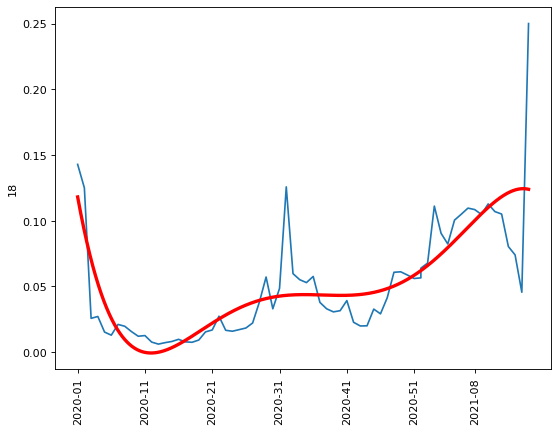

In [138]:
# дом, сидеть, работать, карантин, работа
plot_for_topic_weeks(confident_data, 18, confident_all_datetimes, 0.55)

In [4]:
def plot_for_topic(data, topic_label, all_datetimes, s):
    topic_counter = data.groupby(['best_topic_label', 'formated_date']).agg(['count']).loc[topic_label]['date']
    x = []
    x_label = []
    y = []
    for date in all_datetimes.keys():
        x_label.append(date)
        x.append(datetime.strptime(date, '%Y-%m-%d').timestamp())
        try:
            y.append(topic_counter.loc[date].values[0] / all_datetimes[date])
            if topic_counter.loc[date].values[0] / all_datetimes[date] < 0:
                print(date)
        except:
            y.append(0)
            
    figure(figsize=(8, 6), dpi=80)
    x_int = np.linspace(x[0], x[-1], 10000)
    tck = interpolate.splrep(x, y, k = 5, s = s)
    y_int = interpolate.splev(x_int, tck, der = 0)
    plt.plot(x, y)
    plt.plot(x_int, y_int, linestyle = '-', linewidth = 3, color='red')
    plt.xticks(x[::10], x_label[::10], rotation='vertical')
    plt.ylabel(topic_label)
    plt.show()

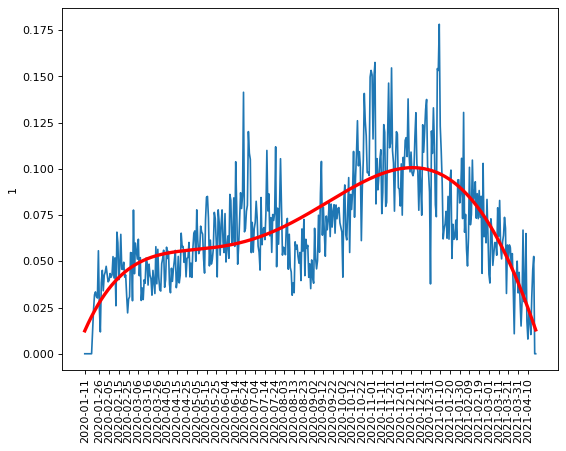

In [5]:
# дом, сидеть, работать, карантин, работа
plot_for_topic(confident_data, 1, confident_all_datetimes, 0.55)

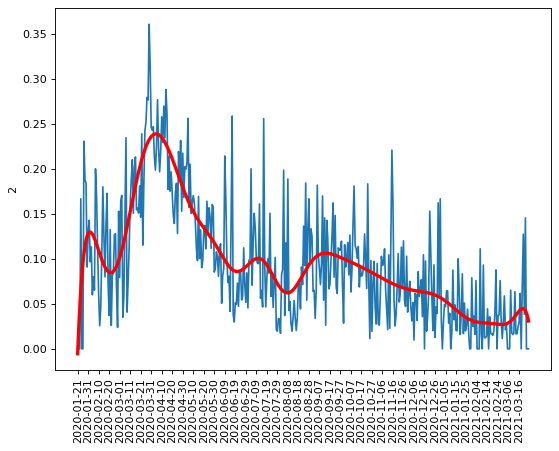

In [29]:
# врач тест больница день температура
plot_for_topic(confident_data, 2, confident_all_datetimes, 0.8)

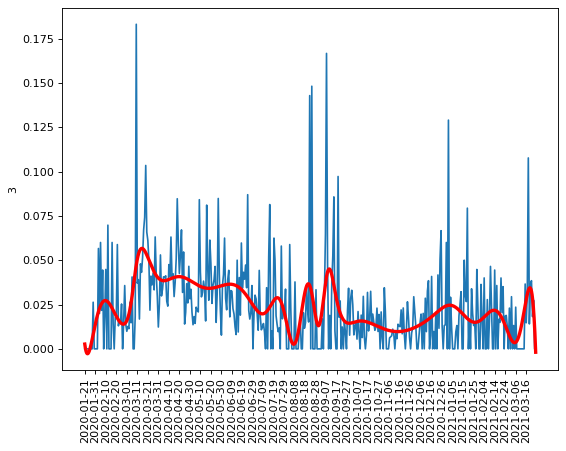

In [32]:
# деньга работать год государство страна
plot_for_topic(confident_data, 3, confident_all_datetimes, 0.21)

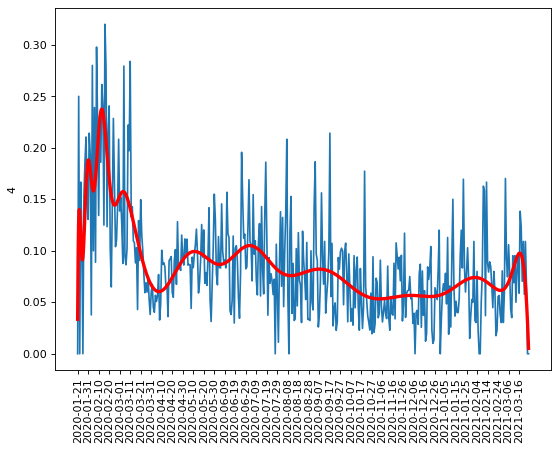

In [40]:
# ребенок ваш знать говорить писать
plot_for_topic(confident_data, 4, confident_all_datetimes, 0.72)

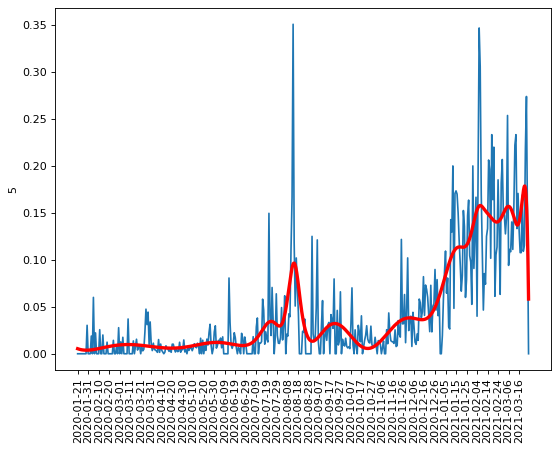

In [42]:
# вирус грипп год болезнь иммунитет
plot_for_topic(confident_data, 5, confident_all_datetimes, 0.5)

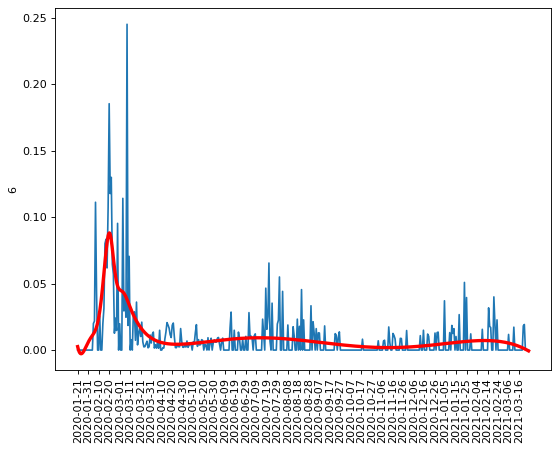

In [49]:
# статистика заболевать день страна число
plot_for_topic(confident_data, 6, confident_all_datetimes, 0.13)

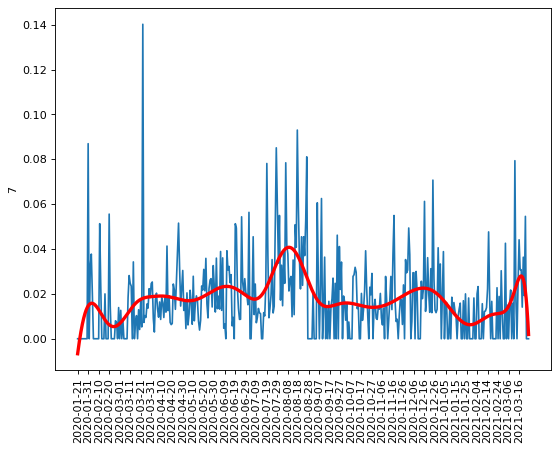

In [56]:
# маска носить рука магазин вирус
plot_for_topic(confident_data, 7, confident_all_datetimes, 0.115)

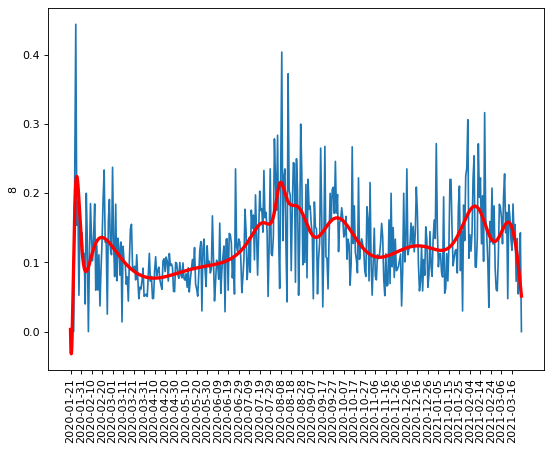

In [65]:
# закон гражданин власть право режим
plot_for_topic(confident_data, 8, confident_all_datetimes, 1.15)

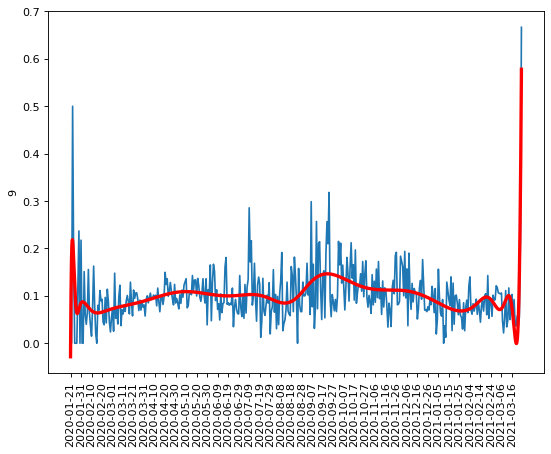

In [75]:
# страна мир россия вирус наш
plot_for_topic(confident_data, 9, confident_all_datetimes, 0.96)

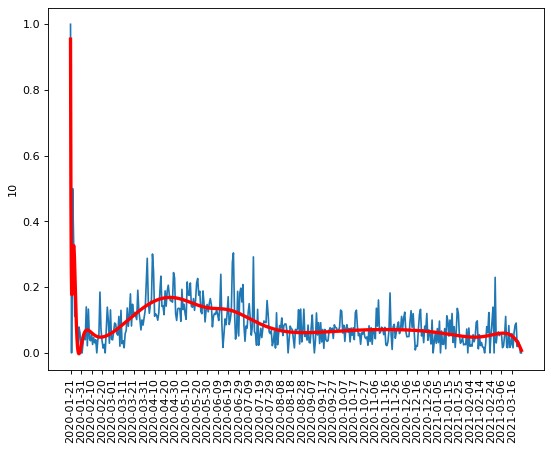

In [78]:
# инфекция случай ковид коронавирус заболевание
plot_for_topic(confident_data, 10, confident_all_datetimes, 0.9)

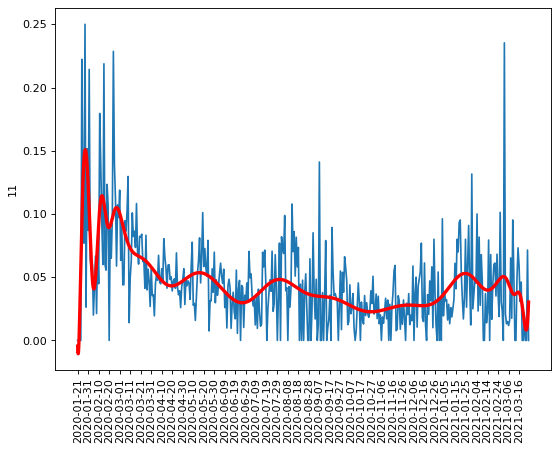

In [87]:
# бог твой ваш жизнь слово
plot_for_topic(confident_data, 11, confident_all_datetimes, 0.38)

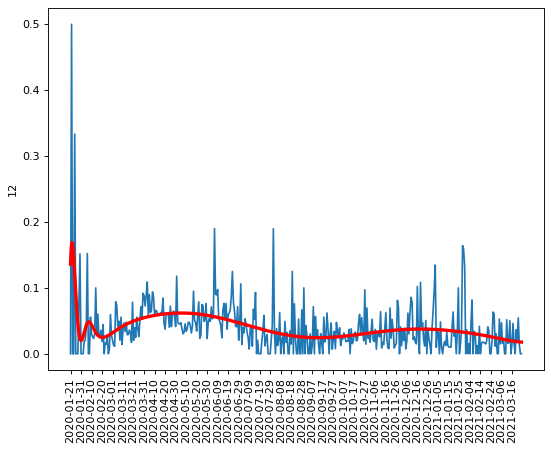

In [107]:
# вакцина вакцинация прививка год первый
plot_for_topic(confident_data, 12, confident_all_datetimes, 0.6)

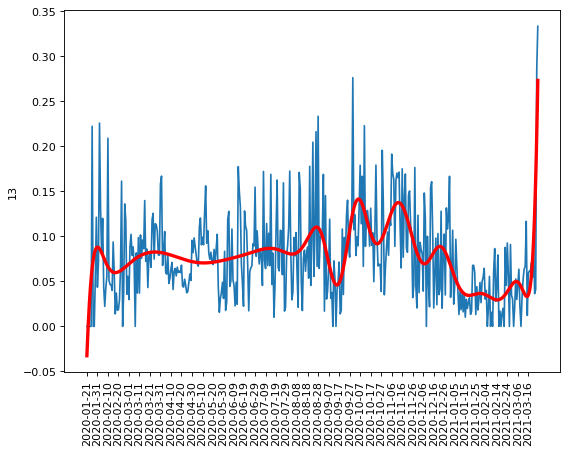

In [103]:
# вирус коронавирус новый животное covid
plot_for_topic(confident_data, 13, confident_all_datetimes, 0.75)

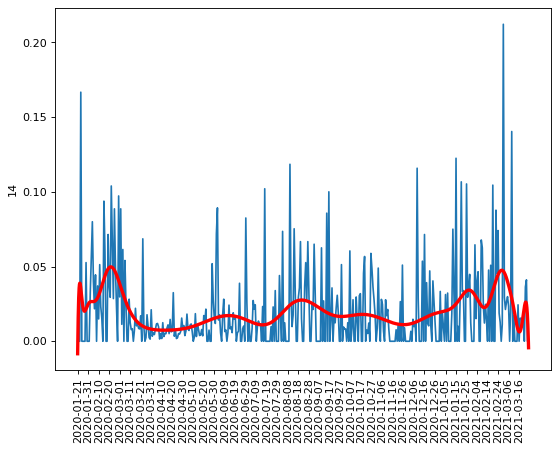

In [98]:
# область москва регион город район
plot_for_topic(confident_data, 14, confident_all_datetimes, 0.29)

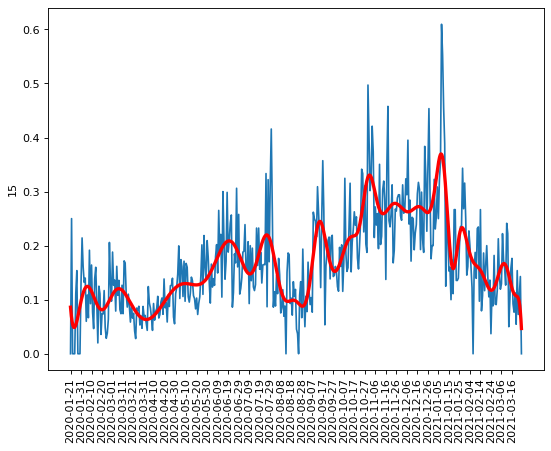

In [93]:
# МУСОР
plot_for_topic(confident_data, 15, confident_all_datetimes, 1.5)